In [81]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
from numpy.ma.core import outer
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

sns.set(rc={'figure.figsize':(4, 4)})
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')

seed = 42
batch_size = 100

np.random.seed(seed)
torch.manual_seed(seed)

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_ic = 1.5
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1.5
        self.w_param_std = 1.0
        self.numInputs = 2
        self.numParams = 2
        self.numOutputs = 1
        self.hidden_size = 25

        # Initialize history variables
        self.total_loss_history = []
        self.loss_ic_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.t0 = torch.tensor([0.0], requires_grad=True).to(self.device)
        self.y0 = torch.tensor([1.0], requires_grad=True).to(self.device)

        # self.predicted_params = torch.zeros((self.numParams,1), requires_grad=True, device=self.device)
        self.predicted_params = torch.zeros((batch_size,2), requires_grad=True, device=self.device)

        # We only have 1 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)


    # make this static so that it can be called independently
    @staticmethod
    def exact_solution(t, x):
        return torch.exp(-t) * torch.sin(torch.pi * x)


    def forward(self, t, x):
        if not torch.is_tensor(t):
            t = torch.from_numpy(t).float().to(self.device)

        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().to(self.device)

        input = torch.cat((t, x), 1)
        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        # prior_param_sample = torch.rand(1, 1, device=self.device).requires_grad_(True)
        prior_param_sample = torch.rand(batch_size, self.hidden_size , device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        y = self.b3(torch.multiply(t2, h2))

        return y


    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)



    def PDE_residual(self, t, x):
        y = self.forward(t, x)
        dy_dt = self.compute_derivative(y, t, 1)
        dy_dx = self.compute_derivative(y, x, 1)
        d2y_dx2 = self.compute_derivative(y, x, 2)

        residual =  dy_dt - torch.multiply(self.predicted_params[:,[0]], d2y_dx2) \
            + torch.exp(- self.predicted_params[:,[1]] * t) * (torch.sin(torch.tensor(np.pi) * x) - torch.tensor(np.pi) ** 2 * torch.sin(torch.tensor(np.pi) * x))
        return residual



    def loss_initial_condition(self, num_samples=100):
        t0 = self.t0 * torch.ones((num_samples, 1), device = self.device)
        x = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        y0_pred = self.forward(t0, x)
        y0_true = self.exact_solution(t0, x)
        loss_ic = torch.mean(torch.square(y0_true - y0_pred))
        return loss_ic


    def loss_boundary_condition(self, num_samples=100):
        x_low = -1
        x_high = 1
        xb_low   = x_low * torch.ones((num_samples, 1),  device = self.device)
        xb_high  = x_high * torch.ones((num_samples, 1), device = self.device)

        t = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True) - 1.0

        yb_low = self.exact_solution(t, xb_low)
        yb_high = self.exact_solution(t, xb_high)

        yb_pred_low = self.forward(t, xb_low)
        yb_pred_high = self.forward(t, xb_high)

        loss_ic = torch.mean(torch.square(yb_pred_low - yb_low)) \
                + torch.mean(torch.square(yb_pred_high - yb_high))
        return loss_ic


    def compute_losses(self):
        loss_ic = self.loss_initial_condition()
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_ic, loss_interior, loss_data, loss_bc


    def loss_data(self, num_samples=100):
        t_data, x_data, y_data = next(iter(train_loader))
        y_pred = self.forward(t_data, x_data)
        loss = torch.mean(torch.square(y_pred - y_data))
        return loss


    def loss_interior(self, num_samples=100):

        interior_t_samples = torch.rand((num_samples, 1),   device=self.device).requires_grad_(True)
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res = self.PDE_residual(interior_t_samples, interior_x_samples)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual


    def sample_parameter_posterior(self, num_samples=100):
        prior_param_samples = torch.rand(num_samples, self.hidden_size, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples



    def update_predicted_params(self, posterior_samples):

        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis

        self.predicted_params = posterior_samples
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute


    def closure(self):
        self.optimizer.zero_grad()
        loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_ic * loss_ic \
                   + self.w_int * loss_interior \
                   + self.w_data * loss_data \
                   + self.w_bc * loss_bc

        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(num_samples=100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        self.log_std_squared_loss = self.w_param_std * torch.mean(torch.log(self.std_params)**2)
        total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)
        return total_loss


    def train(self, epochs, optimizer='Adam', num_samples=100, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)


        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            if epoch % 1000 == 0:
                loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_ic + loss_interior + loss_data + loss_bc

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_ic_history.append(loss_ic.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_bc_history.append(loss_bc.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():.2f}  ' \
                        f'PDE Loss:{loss_interior.item():.2f}  ' \
                        f'BC Loss:{loss_bc.item():.2f}  ' \
                        f'IC Loss: {loss_ic.item():.2f}  ' \
                        # f'Predicted Param:{self.predicted_params.detach().cpu().numpy()[0][0]:.2f}'
                        f'Mean Predicted Param 1: {self.mean_predicted_params[0]:.2f} ' \
                        f'Mean Predicted Param 2: {self.mean_predicted_params[1]:.2f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.2f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.2f}')

In [82]:
def sample_dataset(noise=0.1, numSamples=100, device='cpu'):
    t = torch.linspace(0, 1, numSamples, device=device) # Time domain
    x = torch.linspace(-1, 1, numSamples, device=device) # Space domain

    T, X   = torch.meshgrid(t, x) # Time-Space domain

    y_true = Experiment.exact_solution(T, X)
    T      = T.reshape(-1, 1) # Reshape to 2D to 1D
    X      = X.reshape(-1, 1) # Resahpe to 2D to 1D

    sample_mean = y_true.reshape(-1, 1)
    sample_var  = noise * torch.ones_like(sample_mean)
    Y_noisy     = torch.normal(sample_mean, sample_var)

    return T, X, Y_noisy


def create_train_test_datasets(device='cpu', batch_size = batch_size):
    t_train, x_train, y_train = sample_dataset(noise=0.01, numSamples=10, device=device)
    t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=100, device=device)

    fig = plt.figure()
    size = int(t_test.size(0)**0.5)


    plt.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy(), cmap='jet')
    plt.xlabel('t'); plt.ylabel('x');
    plt.colorbar()

    train_dataset = TensorDataset(t_train, x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(t_test, x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader


# sending only 10 samples due to mismatch
def plot_residuals(net, device, noise=0.0):
    t_test, x_test, y_test = sample_dataset(noise=noise, numSamples=100, device=device)

    # Define batch size
    batch_size = 100

    # Split the test dataset into batches
    t_batches = torch.split(t_test, batch_size)
    x_batches = torch.split(x_test, batch_size)

    # Initialize lists to store results
    mu_results = []
    t_results = []
    x_results = []

    # Iterate over batches
    for t_batch, x_batch in zip(t_batches, x_batches):
        # Call mu for each batch
        mu_batch = net.forward(t_batch, x_batch)
        mu_results.append(mu_batch)
        t_results.append(t_batch)
        x_results.append(x_batch)

    # Concatenate the results
    mu = torch.cat(mu_results)
    t_final = torch.cat(t_results)
    x_final = torch.cat(x_results)

    fig  = plt.figure(figsize=(6, 3))
    ax1  = plt.subplot(121)
    size = int(np.sqrt(x_test.size(0)))

    # Calculate the residuals (difference between predictions and ground truth)
    absDifference  = torch.abs(mu - y_test)
    residuals      = absDifference.view(size, size).cpu().detach().numpy()

    # Create a contour plot of the residuals
    cax = ax1.contourf(t_final.view(size, size).cpu().detach().numpy(),
                       x_final.view(size, size).cpu().detach().numpy(),
                       residuals, cmap='jet')

    plt.colorbar(cax)
    plt.xlabel('t');plt.ylabel('x')
    plt.title("Residual")
    plt.show()


# sending only 10 samples due to mismatch
def make_plot(net, device):
    t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=100, device=device)

    # Define batch size
    batch_size = 100

    # Split the test dataset into batches
    t_batches = torch.split(t_test, batch_size)
    x_batches = torch.split(x_test, batch_size)

    # Initialize lists to store results
    mu_results = []
    t_results = []
    x_results = []

    # Iterate over batches
    for t_batch, x_batch in zip(t_batches, x_batches):
        # Call mu for each batch
        mu_batch = net.forward(t_batch, x_batch)
        mu_results.append(mu_batch)
        t_results.append(t_batch)
        x_results.append(x_batch)

    # Concatenate the results
    mu = torch.cat(mu_results)
    t_final = torch.cat(t_results)
    x_final = torch.cat(x_results)

    fig = plt.figure(figsize=(6, 3))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, sharex=ax1)
    size = int(np.sqrt(x_test.size(0)))

    ax1.contourf(t_final.view(size, size).cpu().detach().numpy(),
                 x_final.view(size, size).cpu().detach().numpy(),
                 mu.view(size, size).cpu().detach().numpy(), cmap='jet')

    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_title('Predicted Result')

    ax2.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy(), cmap='jet')

    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_title('Actual Result')

    plt.subplots_adjust(wspace=0.4)  # Adjust the width space between subplots
    plt.show()


def plot_loss_history(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, net.total_loss_history, label='Total Loss')
    plt.plot(epochs, net.loss_ic_history, label='IC Loss')
    plt.plot(epochs, net.loss_interior_history, label='Interior Loss')
    plt.plot(epochs, net.loss_data_history, label='Data Loss')
    plt.plot(epochs, net.loss_bc_history, label='BC Loss')
    plt.plot(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()


def plot_loss_history_log(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.semilogy(epochs, net.total_loss_history, label='Total Loss')
    plt.semilogy(epochs, net.loss_ic_history, label='IC Loss')
    plt.semilogy(epochs, net.loss_interior_history, label='Interior Loss')
    plt.semilogy(epochs, net.loss_data_history, label='Data Loss')
    plt.semilogy(epochs, net.loss_bc_history, label='BC Loss')
    plt.semilogy(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs (log scale)')
    plt.legend()
    plt.show()


In [83]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

cuda:0
Params: 2103


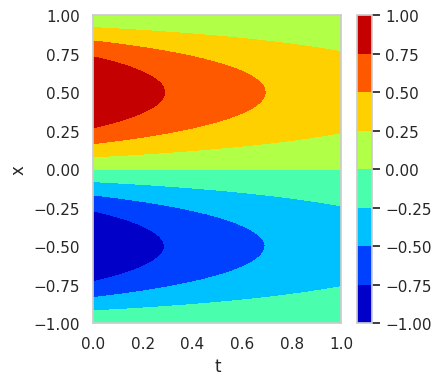

In [84]:
train_loader, test_loader = create_train_test_datasets(device = net.device, batch_size=batch_size)

In [85]:
net.w_ic = 3
net.w_data = 6
net.w_bc   = 1
net.w_int = 1
net.w_param_std = 1

In [86]:
torch.autograd.set_detect_anomaly(True)
net.train(15000, optimizer='Adam', lr=1e-2)

Epoch(Adam):0,  Total Loss:36.70  PDE Loss:35.96  BC Loss:0.01  IC Loss: 0.55  Mean Predicted Param 1: 0.20 Mean Predicted Param 2: -0.13 Std Params:0.05  Std Log Loss:9.94
Epoch(Adam):1000,  Total Loss:0.07  PDE Loss:0.02  BC Loss:0.02  IC Loss: 0.01  Mean Predicted Param 1: 1.36 Mean Predicted Param 2: 1.83 Std Params:1.10  Std Log Loss:0.02
Epoch(Adam):2000,  Total Loss:0.18  PDE Loss:0.14  BC Loss:0.02  IC Loss: 0.01  Mean Predicted Param 1: 1.35 Mean Predicted Param 2: 1.56 Std Params:0.99  Std Log Loss:0.00
Epoch(Adam):3000,  Total Loss:0.06  PDE Loss:0.04  BC Loss:0.01  IC Loss: 0.01  Mean Predicted Param 1: 1.19 Mean Predicted Param 2: 1.32 Std Params:0.79  Std Log Loss:0.04
Epoch(Adam):4000,  Total Loss:0.11  PDE Loss:0.07  BC Loss:0.02  IC Loss: 0.01  Mean Predicted Param 1: 1.22 Mean Predicted Param 2: 1.43 Std Params:0.77  Std Log Loss:0.06
Epoch(Adam):5000,  Total Loss:0.08  PDE Loss:0.04  BC Loss:0.02  IC Loss: 0.01  Mean Predicted Param 1: 1.38 Mean Predicted Param 2: 1.

In [14]:
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': net.optimizer.state_dict(),
    'total_loss_history': net.total_loss_history,
    'loss_ic_history': net.loss_ic_history,
    'loss_interior_history': net.loss_interior_history,
    'loss_data_history': net.loss_data_history,
    'loss_bc_history': net.loss_bc_history,
    'loss_std_history': net.loss_std_history
    # Add other variables if needed
}, f'model_checkpoint_trained.pth')

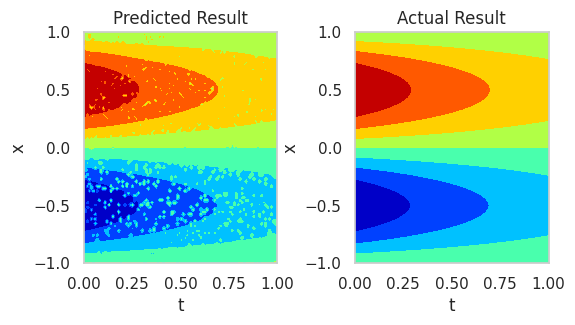

In [89]:
make_plot(net, device=net.device)

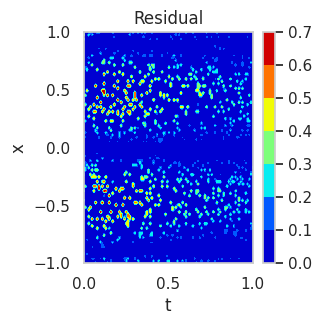

In [90]:
plot_residuals(net, device=net.device, noise=0.0)

In [117]:
def plot_uncertainty(net, device, noise=0.0):
    t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=100, device=device)

    # Define batch size and number of samples
    batch_size = 100
    num_tests = 100

    # Split the test dataset into batches
    t_batches = torch.split(t_test, batch_size)
    x_batches = torch.split(x_test, batch_size)

    mu_tests = []

    # Run the experiment for 100 times
    for _ in range(num_tests):
        mu_results = []
        t_results = []
        x_results = []

        for t_batch, x_batch in zip(t_batches, x_batches):
            mu_batch = net.forward(t_batch, x_batch)
            mu_results.append(mu_batch)
            t_results.append(t_batch)
            x_results.append(x_batch)

        mu = torch.cat(mu_results)
        t_final = torch.cat(t_results)
        x_final = torch.cat(x_results)

        mu_tests.append(mu)  # Append all 100 tests

    # Stack all 100 tests
    mu_tests = torch.stack(mu_tests)

    mu_mean = torch.mean(mu_tests, dim=0)
    mu_std = torch.std(mu_tests, dim=0)

    # Reshape for plotting
    size = int(np.sqrt(x_test.size(0)))
    mu_mean = mu_mean.view(size, size)
    mu_std = mu_std.view(size, size)
    residuals = torch.abs(mu_mean - y_test.view(size, size))

    # Compute and print average MAE and STD
    mae = torch.mean(residuals).item()
    avg_std = torch.mean(mu_std).item()
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"Average Standard Deviation (Uncertainty): {avg_std:.6f}")

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot mean prediction
    cax1 = axes[0].contourf(t_final.view(size, size).cpu().detach().numpy(),
                            x_final.view(size, size).cpu().detach().numpy(),
                            mu_mean.cpu().detach().numpy(), cmap='jet')
    fig.colorbar(cax1, ax=axes[0])
    axes[0].set_title('Predicted Mean')
    axes[0].set_xlabel('t')
    axes[0].set_ylabel('x')


    # Plot residuals
    cax3 = axes[1].contourf(t_final.view(size, size).cpu().detach().numpy(),
                            x_final.view(size, size).cpu().detach().numpy(),
                            residuals.cpu().detach().numpy(), cmap='jet')
    fig.colorbar(cax3, ax=axes[1])
    axes[1].set_title('Error')
    axes[1].set_xlabel('t')
    axes[1].set_ylabel('x')


    # Plot uncertainty (std deviation)
    cax2 = axes[2].contourf(t_final.view(size, size).cpu().detach().numpy(),
                            x_final.view(size, size).cpu().detach().numpy(),
                            mu_std.cpu().detach().numpy(), cmap='jet')
    fig.colorbar(cax2, ax=axes[2])
    axes[2].set_title('Uncertainty')
    axes[2].set_xlabel('t')
    axes[2].set_ylabel('x')

    plt.tight_layout()
    plt.savefig('uncertainty.png', dpi=400)
    plt.show()

Mean Absolute Error (MAE): 0.028164
Average Standard Deviation (Uncertainty): 0.080914


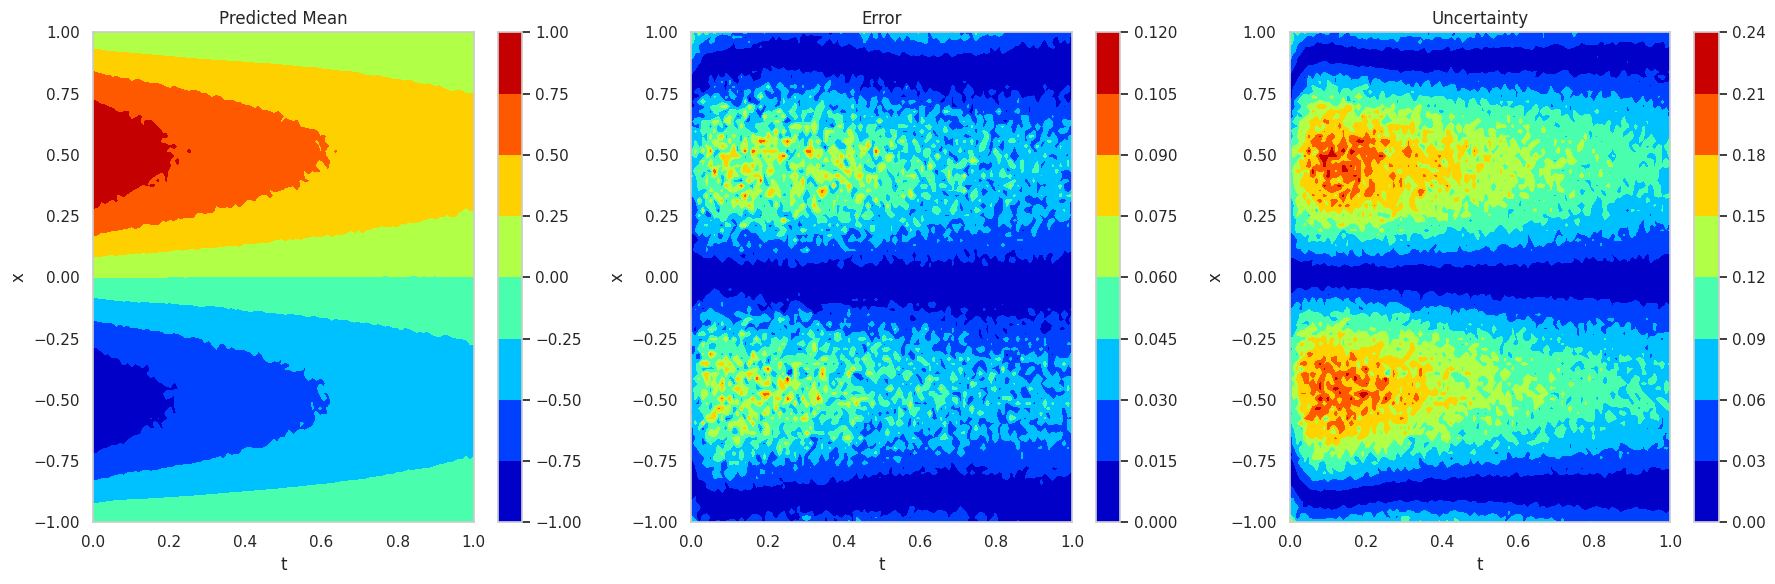

In [118]:
plot_uncertainty(net, device=net.device, noise=0.0)